In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
from decimal import Decimal
from eofs.xarray import Eof
import sys
sys.path.append('/home/ysilvy/bin_TS/')
from drift_functions import lag_linregress_3D

In [23]:
plt.style.use('ggplot')

## De-drift 1000 years of piControl 

In [13]:
# -- Read piControl
datadir = '/data/ysilvy/bin_TS/'
VpiC = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_IPSL-CM5A-LR_piControl_1800-2799.nc').histogram_so_thetao

In [14]:
VpiC['time'] = np.arange(1800,2800)

In [16]:
covpiC,corpiC,slopepiC,interceptpiC,pvalpiC,stderrpiC = lag_linregress_3D(x=VpiC.time,y=VpiC)   

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [17]:
VpiC_drift = VpiC.time*slopepiC + interceptpiC
VpiC_dedrift = VpiC - VpiC_drift + VpiC.mean(dim='time')

In [92]:
VpiC_dedrift_out = VpiC_dedrift.to_dataset(name='histogram_so_thetao')

In [93]:
VpiC_dedrift_out.to_netcdf('/data/ysilvy/bin_TS/volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_piControl_1800-2799.nc')

In [20]:
# -- Perform EOF
solver2=Eof(VpiC_dedrift.stack(z=('so_bin', 'thetao_bin')))
pcs_bis = solver2.pcs(npcs=3)
eofs_bis = solver2.eofs(neofs=3)
variance_frac_bis = solver2.varianceFraction()
var1_bis = variance_frac_bis[0].data*100
var2_bis = variance_frac_bis[1].data*100
var3_bis = variance_frac_bis[2].data*100
eofs_st_1_bis = eofs_bis[0,:].unstack('z')
eofs_st_2_bis = eofs_bis[1,:].unstack('z')
eofs_st_3_bis = eofs_bis[2,:].unstack('z')

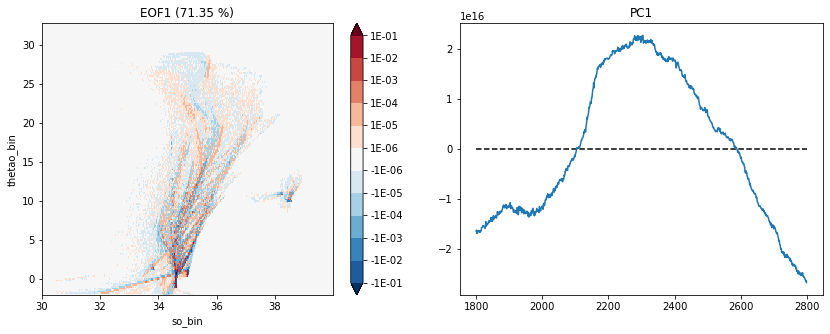

In [22]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = VpiC.time
levels = [-1.e-1,-1.e-2,-1.e-3,-1.e-4,-1.e-5,-1.e-6,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

c = eofs_st_1_bis.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_bis))+'%)')
ax[1].plot(time,pcs_bis[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)

#plt.suptitle(title,fontsize=14,fontweight='bold')

## Dedrift each historical realization 1850-2100

In [24]:
start_points={'r1i1p1':1850,'r2i1p1':1860,'r3i1p1':1870,'r4i1p1':1985}

In [33]:
# -- Cut piControl
t1 = start_points['r1i1p1']
t2 = start_points['r2i1p1']
t3 = start_points['r3i1p1']
t4 = start_points['r4i1p1']
VpiC1 = VpiC.sel(time=slice(t1,t1+250))
VpiC2 = VpiC.sel(time=slice(t2,t2+250))
VpiC3 = VpiC.sel(time=slice(t3,t3+250))
VpiC4 = VpiC.sel(time=slice(t4,t4+250))

In [34]:
# -- Linear regression
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(x=VpiC1.time,y=VpiC1)  
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(x=VpiC2.time,y=VpiC2)  
cov3,cor3,slope3,intercept3,pval3,stderr3 = lag_linregress_3D(x=VpiC3.time,y=VpiC3)  
cov4,cor1,slope4,intercept4,pval4,stderr4 = lag_linregress_3D(x=VpiC4.time,y=VpiC4)  

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [35]:
# -- Drift
drift1 = VpiC1.time*slope1 + intercept1
drift2 = VpiC2.time*slope2 + intercept2
drift3 = VpiC3.time*slope3 + intercept3
drift4 = VpiC4.time*slope4 + intercept4

In [41]:
# -- Read historical members
V1 = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r1i1p1_1850-2100.nc').histogram_so_thetao
V2 = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc').histogram_so_thetao
V3 = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r3i1p1_1850-2100.nc').histogram_so_thetao
V4 = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r4i1p1_1850-2100.nc').histogram_so_thetao

In [52]:
V1['time'] = np.arange(1850,2101)
V2['time'] = np.arange(1850,2101)
V3['time'] = np.arange(1850,2101)
V4['time'] = np.arange(1850,2101)

In [61]:
# -- Dedrift
drift2['time'] = V1['time']; drift3['time'] = V1['time']; drift4['time'] = V1['time'] # Same time axis
V1_dedrift = V1 - drift1 + VpiC1.mean(dim='time')
V2_dedrift = V2 - drift2 + VpiC2.mean(dim='time')
V3_dedrift = V3 - drift3 + VpiC3.mean(dim='time')
V4_dedrift = V4 - drift4 + VpiC4.mean(dim='time')

In [90]:
V1_dedrift_out = V1_dedrift.to_dataset(name='histogram_so_thetao')
V2_dedrift_out = V2_dedrift.to_dataset(name='histogram_so_thetao')
V3_dedrift_out = V3_dedrift.to_dataset(name='histogram_so_thetao')
V4_dedrift_out = V4_dedrift.to_dataset(name='histogram_so_thetao')

In [94]:
V1_dedrift_out.to_netcdf(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r1i1p1_1850-2100.nc')
V2_dedrift_out.to_netcdf(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc')
V3_dedrift_out.to_netcdf(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r3i1p1_1850-2100.nc')
V4_dedrift_out.to_netcdf(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r4i1p1_1850-2100.nc')

In [70]:
# -- Perform EOF
solver=Eof(V4_dedrift.stack(z=('so_bin', 'thetao_bin')))

pcs = solver.pcs(npcs=3)
eofs = solver.eofs(neofs=3)
variance_frac = solver.varianceFraction()
var1 = variance_frac[0].data*100
eofs_st_1 = eofs[0,:].unstack('z')

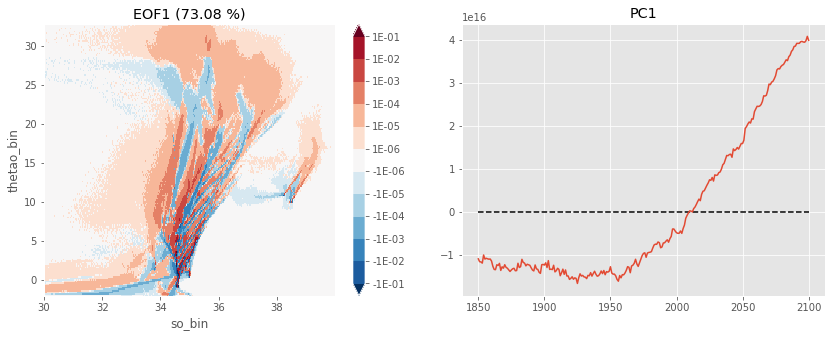

In [71]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2101)

c = eofs_st_1.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[1].plot(time,pcs[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)

In [72]:
# -- Perform EOF
solver=Eof(V4.stack(z=('so_bin', 'thetao_bin')))

pcs = solver.pcs(npcs=3)
eofs = solver.eofs(neofs=3)
variance_frac = solver.varianceFraction()
var1 = variance_frac[0].data*100
eofs_st_1 = eofs[0,:].unstack('z')

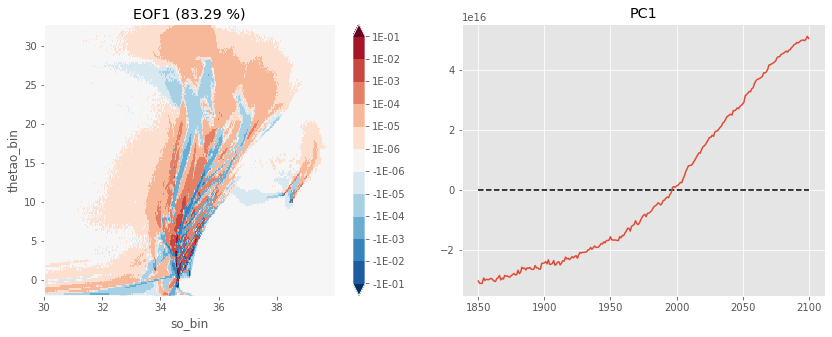

In [73]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2101)

c = eofs_st_1.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[1].plot(time,pcs[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)

In [74]:
def red_zeros(V):
    """Center and reduce array, then replace nans with zeros (nans come from dividing by zero in the reduction)"""
    V_red = V - V.mean(dim='time')
    V_red = V_red/V.std(dim='time')
    V_red = xr.where(np.isnan(V_red)==False,V_red,0)
    return V_red

In [76]:
# -- Center and reduce data prior to performing EOF
V4_dedrift_red = red_zeros(V4_dedrift)

In [77]:
# -- Perform EOF
solver=Eof(V4_dedrift_red.stack(z=('so_bin', 'thetao_bin')))

pcs = solver.pcs(npcs=3)
eofs = solver.eofs(neofs=3)
variance_frac = solver.varianceFraction()
var1 = variance_frac[0].data*100
eofs_st_1 = eofs[0,:].unstack('z')

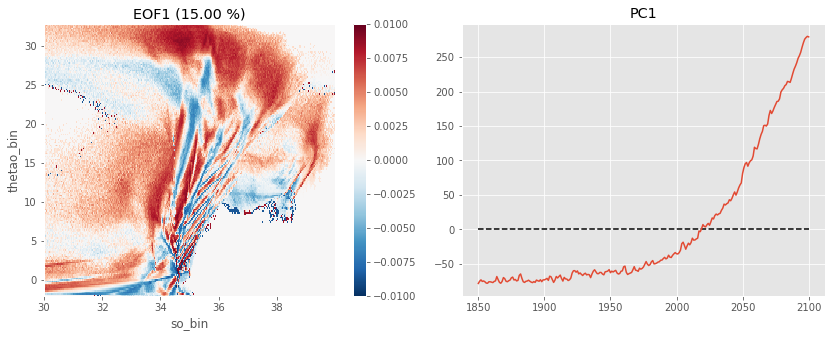

In [81]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2101)

vmin = -0.01 
vmax = 0.01 

c = eofs_st_1.T.plot(ax=ax[0],cmap='RdBu_r',add_colorbar=False,vmin=vmin,vmax=vmax,center=0)
cb = fig.colorbar(c,ax=ax[0],label='')
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[1].plot(time,pcs[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)